Name: Shar Clark

# Imports

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib





# Functions

In [2]:
def summarize_df(df_):
    df = df_.copy()
    report = pd.DataFrame({
                        'dtype':df.dtypes,
                        '# null': df.isna().sum(),
                        'null (%)': df.isna().sum()/len(df)*100,
                        'nunique':df.nunique(),
                        "min":df.min(),
                        'max':df.max()
             })
    report.index.name='Column'
    return report.reset_index()

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [58]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [64]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [62]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [102]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [103]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

# Load and Clean Data

In [4]:
#load in data
df = pd.read_csv('Data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
summarize_df(df)

/var/folders/xw/n3kj7zts4fjg477wm5hmpsyc0000gn/T/ipykernel_6763/836355026.py:8: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  "min":df.min(),
/var/folders/xw/n3kj7zts4fjg477wm5hmpsyc0000gn/T/ipykernel_6763/836355026.py:9: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'max':df.max()


,Column,dtype,# null,null (%),nunique,min,max
0,Item_Fat_Content,object,0,0.000000,5,LF,reg
1,Item_Identifier,object,0,0.000000,1559,DRA12,NCZ54
2,Item_MRP,float64,0,0.000000,5938,31.29,266.8884
3,Item_Outlet_Sales,float64,0,0.000000,3493,33.29,13086.9648
4,Item_Type,object,0,0.000000,16,Baking Goods,Starchy Foods
5,Item_Visibility,float64,0,0.000000,7880,0.0,0.328391
6,Item_Weight,float64,1463,17.165317,415,4.555,21.35
7,Outlet_Establishment_Year,int64,0,0.000000,9,1985,2009
8,Outlet_Identifier,object,0,0.000000,10,OUT010,OUT049
9,Outlet_Location_Type,object,0,0.000000,3,Tier 1,Tier 3


In [6]:
df.describe().round(4)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.0000,8523.0000,8523.0000,8523.0000,8523.0000
mean,12.8576,0.0661,140.9928,1997.8319,2181.2889
std,4.6435,0.0516,62.2751,8.3718,1706.4996
min,4.5550,0.0000,31.2900,1985.0000,33.2900
25%,8.7738,0.0270,93.8265,1987.0000,834.2474
50%,12.6000,0.0539,143.0128,1999.0000,1794.3310
75%,16.8500,0.0946,185.6437,2004.0000,3101.2964
max,21.3500,0.3284,266.8884,2009.0000,13086.9648


## Missing Values

In [7]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
#look further to figure out how to address missing values
df[df.isna().any(axis = 1)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.20,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.20,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
...,...,...,...,...,...,...,...,...,...,...,...,...
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8508,FDW31,11.35,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.10,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.00,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [9]:
#addressing missing values for Outlet_size
df[('Outlet_Size')].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [10]:
#too many to impute with, fill with new column
df['Outlet_Size'].fillna('MISSING', inplace=True)
print(df[('Outlet_Size')].value_counts())
df.isna().sum()

Medium     2793
MISSING    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
#addressing missing values for 'Item_Weight'
## going to fill in for the average of the column

df_weight = df['Item_Weight'].mean()
df['Item_Weight'].fillna(value = df_weight, inplace=True)

df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Inconsistent Categories and Data

In [12]:
df.nunique()


Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [13]:
#dropping unecessary columns
df = df.drop(columns=['Item_Identifier', 'Outlet_Identifier',])

In [14]:
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index

for col in str_cols:
    print(f"- Column= {col}")
    print(df[col].value_counts(dropna=False))
    print('\n\n')

- Column= Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



- Column= Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



- Column= Outlet_Size
Medium     2793
MISSING    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64



- Column= Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64



- Column= Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Super

In [15]:
# Fix fat content
df.replace(['low fat', 'reg', 'LF'], ['Low Fat', 'Regular', 'Low Fat'], inplace = True)

In [16]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Ordinal Encoding Categorical Categories

In [17]:
#repoutletdic = {'MISSING':0, 'Small':1, 'Medium':2, 'High':3}
#df['Outlet_Size'].replace(repoutletdic, inplace=True)
#df['Outlet_Size']

In [18]:
repdic_fatcont = {'Low Fat':1, 'Regular':2}
df['Item_Fat_Content'].replace(repdic_fatcont, inplace=True)
df['Item_Fat_Content']

0       1
1       2
2       1
3       2
4       1
       ..
8518    1
8519    2
8520    1
8521    2
8522    1
Name: Item_Fat_Content, Length: 8523, dtype: int64

In [19]:
#rep_loctype = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3':3}
#df['Outlet_Location_Type'].replace(rep_loctype, inplace=True)
#df['Outlet_Location_Type']

In [20]:
#rep_outtype = {'Grocery Store':0, 'Supermarket Type1': 1, 'Supermarket Type2': 2, 'Supermarket Type3': 3}
#df['Outlet_Type'].replace(rep_outtype, inplace=True)
#df['Outlet_Type']

In [21]:
#repdic_type = {'Fruits and Vegetables': 0, 'Snack Foods': 2, 'Household' :3, 'Frozen Foods':4, 'Dairy': 5, 'Canned':6 , 'Baking Goods':7, 'Health and Hygiene':8, 'Soft Drinks':9, 'Meat':10, 'Breads':11, 'Hard Drinks':12, 'Others':13, 'Starchy Foods':14, 'Breakfast': 15, 'Seafood':16 }
#df['Item_Type'].replace(repdic_type,inplace=True)
#df['Item_Type']

In [22]:
for col in str_cols:
    print(f"- Column= {col}")
    print(df[col].value_counts(dropna=False))
    print('\n\n')

- Column= Item_Fat_Content
1    5517
2    3006
Name: Item_Fat_Content, dtype: int64



- Column= Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



- Column= Outlet_Size
Medium     2793
MISSING    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64



- Column= Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64



- Column= Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_

In [23]:
df.info()
#no missing and all numeric now. Ready for modeling. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   int64  
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 666.0+ KB


# Modeling

In [24]:
#split
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [26]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year']

In [27]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputer
mean_imputer = SimpleImputer(strategy='mean')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [28]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [29]:
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [30]:
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [31]:
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [32]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough', 
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15e2859a0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15e285a90>)],
                  verbose_feature_names_out=False)

In [33]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [34]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,1,0.029565,Household,256.4646,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,2,0.000000,Snack Foods,179.7660,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,2,0.158716,Meat,157.2946,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,1,0.014628,Baking Goods,82.3250,2004,Small,Tier 2,Supermarket Type1
4810,19.350,1,0.016645,Frozen Foods,120.9098,2002,MISSING,Tier 2,Supermarket Type1


In [35]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.35,1.0,0.029565,256.4646,2009.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,15.25,2.0,0.000000,179.7660,2009.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,12.35,2.0,0.158716,157.2946,1999.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [36]:
X_test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
7503,14.300000,1,0.026300,Frozen Foods,79.4302,1987,High,Tier 3,Supermarket Type1
2957,7.930000,1,0.071136,Health and Hygiene,42.7086,1997,Small,Tier 1,Supermarket Type1
7031,14.500000,2,0.041313,Canned,42.0454,1999,Medium,Tier 1,Supermarket Type1
1084,12.857645,2,0.044767,Soft Drinks,173.7054,1985,Medium,Tier 3,Supermarket Type3
856,10.195000,2,0.012456,Meat,197.5110,2004,Small,Tier 2,Supermarket Type1


In [37]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,1.0,0.026300,79.4302,1987.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2957,7.93,1.0,0.071136,42.7086,1997.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,14.50,2.0,0.041313,42.0454,1999.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [38]:
#test and train are now scaled and fitted and saved as their own dataframes
##double check that y test lines up with x test. it does. 
y_test.head(3)

7503    1743.0644
2957     356.8688
7031     377.5086
Name: Item_Outlet_Sales, dtype: float64

## LinearRegression

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


- R squared is very low for this model. 
- lets take a look at the coefficients

In [40]:
lin_reg.coef_

array([-1.94181707e+00,  6.26252336e+01, -4.23390180e+02,  1.57209242e+01,
        2.83096799e+01, -1.86125405e+01, -4.72608587e+01,  2.67485232e+01,
        8.90365370e+00, -1.24947555e+02, -2.03831667e+01,  2.71414890e+01,
       -4.71764142e+00,  8.41287319e+00, -1.31027942e+01, -3.04774272e+01,
       -4.54262663e+01,  3.08888596e+02, -4.05449331e+01, -5.80982758e+01,
        2.34763241e+01,  4.95828969e+02, -2.74271362e+02, -8.33302805e+01,
       -1.38227326e+02,  1.04720964e+02,  5.35493794e+01, -1.58270344e+02,
       -1.55826505e+03, -2.39151045e+01, -4.02580314e+02,  1.98476047e+03])

In [41]:
## Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
print(len(feature_names))
len(lin_reg.coef_) == len(feature_names)

32
32


True

In [42]:
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

Item_Weight                          -1.941817
Item_Fat_Content                     62.625234
Item_Visibility                    -423.390180
Item_MRP                             15.720924
Outlet_Establishment_Year            28.309680
Item_Type_Baking Goods              -18.612541
Item_Type_Breads                    -47.260859
Item_Type_Breakfast                  26.748523
Item_Type_Canned                      8.903654
Item_Type_Dairy                    -124.947555
Item_Type_Frozen Foods              -20.383167
Item_Type_Fruits and Vegetables      27.141489
Item_Type_Hard Drinks                -4.717641
Item_Type_Health and Hygiene          8.412873
Item_Type_Household                 -13.102794
Item_Type_Meat                      -30.477427
Item_Type_Others                    -45.426266
Item_Type_Seafood                   308.888596
Item_Type_Snack Foods               -40.544933
Item_Type_Soft Drinks               -58.098276
Item_Type_Starchy Foods              23.476324
Outlet_Size_H

In [43]:
# use .loc to add the intercept to the series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                           -1.941817
Item_Fat_Content                      62.625234
Item_Visibility                     -423.390180
Item_MRP                              15.720924
Outlet_Establishment_Year             28.309680
Item_Type_Baking Goods               -18.612541
Item_Type_Breads                     -47.260859
Item_Type_Breakfast                   26.748523
Item_Type_Canned                       8.903654
Item_Type_Dairy                     -124.947555
Item_Type_Frozen Foods               -20.383167
Item_Type_Fruits and Vegetables       27.141489
Item_Type_Hard Drinks                 -4.717641
Item_Type_Health and Hygiene           8.412873
Item_Type_Household                  -13.102794
Item_Type_Meat                       -30.477427
Item_Type_Others                     -45.426266
Item_Type_Seafood                    308.888596
Item_Type_Snack Foods                -40.544933
Item_Type_Soft Drinks                -58.098276
Item_Type_Starchy Foods               23

In [44]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

Item_Weight                            -1.94
Item_Fat_Content                       62.63
Item_Visibility                      -423.39
Item_MRP                               15.72
Outlet_Establishment_Year              28.31
Item_Type_Baking Goods                -18.61
Item_Type_Breads                      -47.26
Item_Type_Breakfast                    26.75
Item_Type_Canned                        8.90
Item_Type_Dairy                      -124.95
Item_Type_Frozen Foods                -20.38
Item_Type_Fruits and Vegetables        27.14
Item_Type_Hard Drinks                  -4.72
Item_Type_Health and Hygiene            8.41
Item_Type_Household                   -13.10
Item_Type_Meat                        -30.48
Item_Type_Others                      -45.43
Item_Type_Seafood                     308.89
Item_Type_Snack Foods                 -40.54
Item_Type_Soft Drinks                 -58.10
Item_Type_Starchy Foods                23.48
Outlet_Size_High                      495.83
Outlet_Siz

### Reducing Multicollinearity

#### drop='if_binary'

In [45]:
# recreating x/y data with drop='if_binary'

#split
X = df.drop('Item_Outlet_Sales', axis=1).copy()
y = df['Item_Outlet_Sales'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputer
mean_imputer = SimpleImputer(strategy='mean')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough', 
                                      verbose_feature_names_out=False)

In [47]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df2 = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df2 = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df2.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,1.00,0.03,79.43,"1,987.00",0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2957,7.93,1.00,0.07,42.71,"1,997.00",0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,14.50,2.00,0.04,42.05,"1,999.00",0.00,0.00,0.00,1.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [48]:
#refit after drop if binary argument
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train_df2, y_train)
evaluate_regression(lin_reg, X_train_df2, y_train, X_test_df2,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


In [49]:
## Saving the coefficients
coeffs2 = pd.Series(lin_reg2.coef_, index= feature_names)
coeffs2['intercept'] = lin_reg2.intercept_
coeffs2

Item_Weight                            -1.94
Item_Fat_Content                       62.63
Item_Visibility                      -423.39
Item_MRP                               15.72
Outlet_Establishment_Year              28.31
Item_Type_Baking Goods                -18.61
Item_Type_Breads                      -47.26
Item_Type_Breakfast                    26.75
Item_Type_Canned                        8.90
Item_Type_Dairy                      -124.95
Item_Type_Frozen Foods                -20.38
Item_Type_Fruits and Vegetables        27.14
Item_Type_Hard Drinks                  -4.72
Item_Type_Health and Hygiene            8.41
Item_Type_Household                   -13.10
Item_Type_Meat                        -30.48
Item_Type_Others                      -45.43
Item_Type_Seafood                     308.89
Item_Type_Snack Foods                 -40.54
Item_Type_Soft Drinks                 -58.10
Item_Type_Starchy Foods                23.48
Outlet_Size_High                      495.83
Outlet_Siz

#### drop='first'

In [50]:
#split
X = df.drop('Item_Outlet_Sales', axis=1).copy()
y = df['Item_Outlet_Sales'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [51]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputer
mean_imputer = SimpleImputer(strategy='mean')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough', 
                                      verbose_feature_names_out=False)

In [52]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df3 = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df3 = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df3.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,1.00,0.03,79.43,"1,987.00",0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
2957,7.93,1.00,0.07,42.71,"1,997.00",0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
7031,14.50,2.00,0.04,42.05,"1,999.00",0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [54]:
#refit
lin_reg3 = LinearRegression()
lin_reg3.fit(X_train_df3, y_train)
evaluate_regression(lin_reg3, X_train_df3, y_train, X_test_df3,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


In [55]:
lin_reg.feature_names_in_

array(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [56]:
## Saving the coefficients
coeffs3 = pd.Series(lin_reg3.coef_, index= lin_reg3.feature_names_in_)
coeffs3['intercept'] = lin_reg3.intercept_
coeffs3

Item_Weight                            -1.94
Item_Fat_Content                       62.63
Item_Visibility                      -423.39
Item_MRP                               15.72
Outlet_Establishment_Year              28.31
Item_Type_Breads                      -28.65
Item_Type_Breakfast                    45.36
Item_Type_Canned                       27.52
Item_Type_Dairy                      -106.34
Item_Type_Frozen Foods                 -1.77
Item_Type_Fruits and Vegetables        45.75
Item_Type_Hard Drinks                  13.89
Item_Type_Health and Hygiene           27.03
Item_Type_Household                     5.51
Item_Type_Meat                        -11.86
Item_Type_Others                      -26.81
Item_Type_Seafood                     327.50
Item_Type_Snack Foods                 -21.93
Item_Type_Soft Drinks                 -39.49
Item_Type_Starchy Foods                42.09
Outlet_Size_MISSING                  -770.10
Outlet_Size_Medium                   -579.16
Outlet_Siz

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


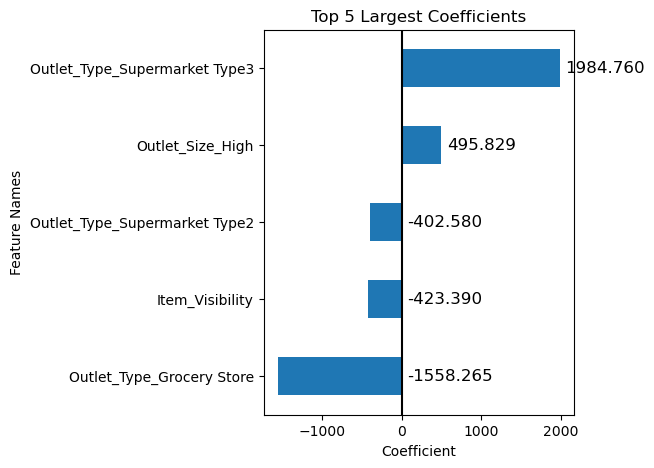

In [71]:
#will use first model for coefficients. Not sure if these numbers can go down
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)
coeffs = get_coeffs_linreg(lin_reg)
plot_coeffs(coeffs,top_n=5,annotate=True);

In [78]:
plt.savefig('Data/Top_5LinReg.png',dpi=300)

<Figure size 640x480 with 0 Axes>

## Random Forest

In [108]:
from sklearn.ensemble import RandomForestRegressor

ranfor = RandomForestRegressor()
ranfor.fit(X_train_df,y_train)
evaluate_regression(ranfor, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 428.35
Test Data:	R^2= 0.55	RMSE= 1112.78


- Test R Squared is much lower than the testing data. This model is overfit.   
- Lets take a look at the coeffecients anyways. 

In [109]:
ranfor.feature_importances_

array([0.05366376, 0.00925892, 0.10018332, 0.44386174, 0.03526774,
       0.00402908, 0.00234958, 0.00260765, 0.00431244, 0.00666053,
       0.00577256, 0.00773709, 0.0029026 , 0.00405349, 0.00648924,
       0.00365769, 0.00155449, 0.00160752, 0.00843357, 0.00555106,
       0.00309722, 0.00241123, 0.004621  , 0.00424781, 0.00674365,
       0.00483537, 0.00347193, 0.00332124, 0.1937122 , 0.00196379,
       0.00160136, 0.06001914])

In [110]:
## Checking the number of feature importances matches the # of columns
print(len(ranfor.feature_importances_))
print(len(X_train_df.columns))
len(ranfor.feature_importances_) == len(X_train_df.columns)

32
32


True

In [111]:
feature_names_ranfor = ranfor.feature_names_in_
len(feature_names_ranfor)

32

In [112]:
## Saving the feature importances
importances = pd.Series(ranfor.feature_importances_, index= feature_names_ranfor,
                       name='Feature Importance')
importances

Item_Weight                       0.05
Item_Fat_Content                  0.01
Item_Visibility                   0.10
Item_MRP                          0.44
Outlet_Establishment_Year         0.04
Item_Type_Baking Goods            0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Canned                  0.00
Item_Type_Dairy                   0.01
Item_Type_Frozen Foods            0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Hard Drinks             0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Household               0.01
Item_Type_Meat                    0.00
Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Snack Foods             0.01
Item_Type_Soft Drinks             0.01
Item_Type_Starchy Foods           0.00
Outlet_Size_High                  0.00
Outlet_Size_MISSING               0.00
Outlet_Size_Medium                0.00
Outlet_Size_Small                 0.01
Outlet_Location_Type_Tier

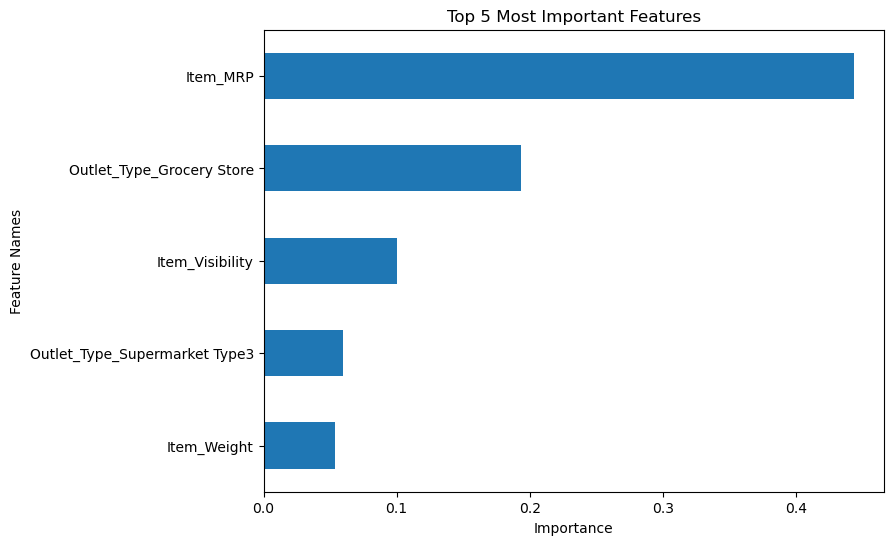

In [113]:
plot_importance(importances, top_n=5);

In [106]:
plt.savefig('Data/Top_5RandomForest.png',dpi=300)

<Figure size 640x480 with 0 Axes>

# Save Models

## Linear Regression

In [107]:
import joblib

linreg_export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'LinearRegression':lin_reg}
joblib.dump(linreg_export, 'LinReg_Project1Revisited.joblib')

['LinReg_Project1Revisited.joblib']

## Random Forest

In [114]:
ranfor_export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForestRegressor':ranfor}
joblib.dump(ranfor_export, 'RanFor_Project1Revisited.joblib')

['RanFor_Project1Revisited.joblib']